In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import toeplitz
import time

In [8]:
fs=50e3
frac_bw = 0.2
nn=200
df = fs/nn
bw=int(frac_bw*nn) #bandwidth
print(bw, bw*df)

40 10000.0


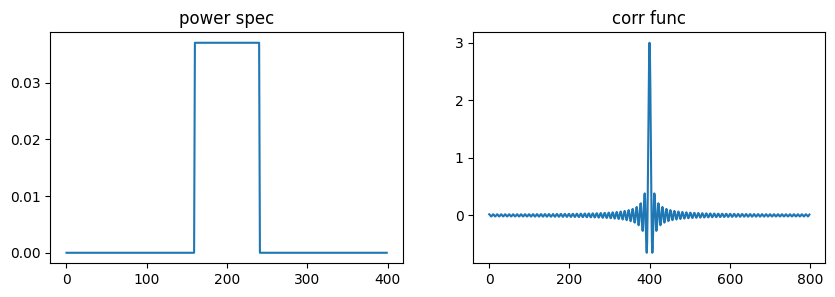

In [9]:
snr=3
# eigval=np.ones(2*nn)/(2*nn) #white noise ps. defaults to sigma^2 = 1
eigval=np.zeros(2*nn)
# eigval[kk-bw:kk+bw+1]+=snr/(2*bw+1)
eigval[:bw+1]+=snr/(2*bw+1)
eigval[-bw:]+=snr/(2*bw+1)
# eigval[0]=0
f=plt.gcf()
f.set_size_inches(10,3)
plt.subplot(121)
plt.title("power spec")
plt.plot(np.fft.fftshift(eigval))
plt.subplot(122)
plt.title("corr func")
acf2=np.fft.fft(eigval).real #doing fft instead of ifft so I dont have to multiply by N
plt.plot(np.fft.fftshift(acf))

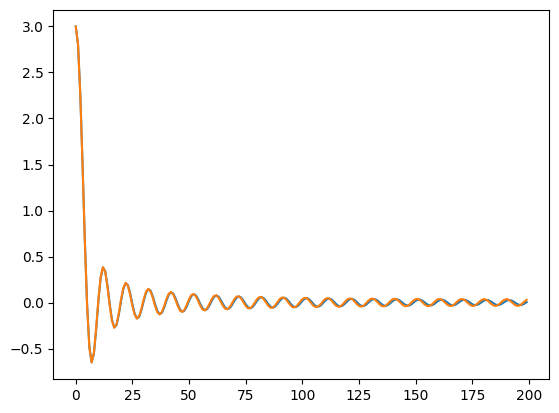

In [10]:
plt.plot(acf[:200])
plt.plot(acf2[:200])

In [11]:
acf[0], acf2[0]

(3.0, 3.0)

In [15]:
yfull=np.fft.fft(np.sqrt(eigval)*x)

In [17]:
yfull[1], yfull[-1]

((-1.3678869857360216+0.921857534099471j),
 (-1.3678869857360212-0.9218575340994712j))

In [6]:
x=np.random.randn(2*nn)
y=np.sqrt(2)*np.fft.fft(np.sqrt(eigval)*x)[:nn].copy()

In [7]:
yr=y.real
yi=y.imag

In [9]:
yn=len(y)
print("len y is", yn)

len y is 200


In [46]:
# acf=get_acf_analytical(bw,len(y)+1,nn,snr)[1:]
C=toeplitz(acf[:yn+1])+np.eye(yn+1)*1e-3
Cinv=np.linalg.inv(C)
# Cinv=np.linalg.pinv(S2,hermitian=True,rcond=1e-8)
Cinv@C

array([[ 1.00000000e+00,  1.33161069e-11,  6.66174256e-12, ...,
        -2.78114055e-12, -3.57527348e-12, -3.46891169e-12],
       [-3.75421801e-11,  1.00000000e+00, -3.17602302e-11, ...,
         1.04260951e-11,  1.33122425e-11,  1.31612533e-11],
       [ 5.89327786e-11,  9.76403415e-11,  1.00000000e+00, ...,
        -1.81020243e-11, -2.22490704e-11, -2.18097707e-11],
       ...,
       [-8.14930126e-13, -8.23299964e-13, -7.29053744e-13, ...,
         1.00000000e+00,  3.00913076e-13,  1.16431500e-13],
       [ 2.30539690e-13,  2.33848817e-13,  2.15379398e-13, ...,
        -4.05306947e-13,  1.00000000e+00, -3.26191221e-13],
       [ 7.10542736e-15,  2.66453526e-14,  4.44089210e-14, ...,
         2.27373675e-13,  3.61347378e-13,  1.00000000e+00]])

In [54]:
yn

200

In [55]:
# acf=get_acf_analytical(bw,len(y)+1,nn,snr)[1:]
Cs=toeplitz(acf[:yn])+np.eye(yn)*1e-3
Cinvs=np.linalg.inv(Cs) #one element smaller
# Cinv=np.linalg.pinv(S2,hermitian=True,rcond=1e-8)

In [ ]:
osamp=5000

In [ ]:
np.exp(2j*np.pi*np.arange(

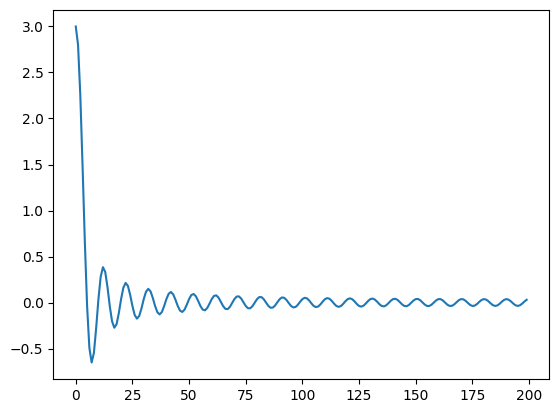

In [14]:
plt.plot(acf[:yn])

In [47]:
coeffs=-Cinv[-1,:-1]/Cinv[-1,-1]
coeffs=coeffs.real
sigma=1/np.sqrt(Cinv[-1,-1])

In [27]:
ks=np.arange(1,bw+1)
ks

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40])

In [78]:
len(ks)

40

In [80]:
def get_corr_vec(eigval,ks,taus):
    # get correlation vector (last col/row) of corr matrix
    bw=len(ks)
    return eigval[1:bw+1]@np.exp(2j*np.pi*np.outer(ks,taus)/(2*nn))+eigval[-bw:]@np.exp(2j*np.pi*np.outer(-ks,taus)/(2*nn))+eigval[0]

In [92]:
B2=get_corr_vec(eigval,ks,np.linspace(nn,1,nn))

In [62]:
B=C[-1,:-1]
# B=B[::-1]
np.max(np.abs(B.T@Cinvs-coeffs))

8.848755062018654e-13

In [94]:
np.max(np.abs(B2.T@Cinvs-coeffs))

3.3498048085389698e-12

In [113]:
sigma2 = np.sqrt(C[0,0]-B.T@Cinvs@B)
assert(np.allclose(sigma2,sigma))

In [19]:
extra=3000
err=sigma*(np.random.randn(extra)+1j*np.random.randn(extra))
y_long = np.hstack([y,np.zeros(extra,dtype=y.dtype)])
y_long_filled=y_long.copy()
for ii in range(extra):
    jj = len(y) + ii
    y_long_filled[jj]=coeffs@y_long_filled[jj-len(coeffs):jj] + err[ii]

In [137]:
osamp=10
coeffs_arr=np.zeros((osamp,nn), dtype='float64') #for sub-sample point 1 to osamp where final point is essentially the next "big" point
sigma_arr=np.zeros(osamp,dtype='float64')
for oo in range(1,osamp+1): #start from n + delta and go till n+1'th point
    vec=get_corr_vec(eigval,ks,np.linspace(nn-1,0,nn)+oo/osamp) #this is the corr array. use past n pts to predict next pt
    coeffs_arr[oo-1,:]=vec
    sigma_arr[oo-1] = np.sqrt(C[0,0]-vec.T@Cinvs@vec)
coeffs_arr = coeffs_arr@Cinvs #coeffs = corr dot Cinv_small

/tmp/ipykernel_159682/1755557458.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs_arr[oo-1,:]=vec
/tmp/ipykernel_159682/1755557458.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  sigma_arr[oo-1] = np.sqrt(C[0,0]-vec.T@Cinvs@vec)


In [134]:
np.max(np.abs(coeffs_arr[-1,:]-coeffs))

3.3451002384721207e-12

In [210]:
sigma_arr

array([0.04508485, 0.04748754, 0.05032712, 0.05362429, 0.05739405,
       0.0616466 , 0.06638839, 0.07162325, 0.07735326, 0.08357946])

In [135]:
coeffs_arr@y

array([2.5476448 -0.1680157j , 2.61935643-0.1512556j ,
       2.68281153-0.13445497j, 2.73776794-0.11764127j,
       2.78401188-0.10084182j, 2.82135861-0.08408377j,
       2.84965317-0.06739406j, 2.86877087-0.05079936j,
       2.87861773-0.03432608j, 2.87913089-0.01800029j])

In [146]:
coeffs@y #last element

(2.8791308929211654-0.018000292147381566j)

In [150]:
sigma

0.08357945699465831

In [151]:
sigma_arr

array([0.04508485, 0.04748754, 0.05032712, 0.05362429, 0.05739405,
       0.0616466 , 0.06638839, 0.07162325, 0.07735326, 0.08357946])

In [209]:
extra=nn
y_long = np.hstack([y,np.zeros(extra,dtype=y.dtype)])
niter=1000
t1=time.time()
for i in range(niter):
    y_osamp = np.zeros(extra*osamp+1,dtype=y.dtype) #even idx to end at. 
    # y_osamp_smooth = np.zeros(extra*osamp+1,dtype=y.dtype) #even idx to end at. 
    for ii in range(extra):
        jj = len(y) + ii
        # print("using big points",jj-nn, "to", jj-1)
        # print("filling small pts",ii*osamp+1,'to',(ii+1)*osamp)
        # print(coeffs_arr@y_long[jj-nn:jj])
        # y_osamp_smooth[ii*osamp+1:(ii+1)*osamp+1]=coeffs_arr@y_long[jj-nn:jj] 
        # y_osamp[ii*osamp+1:(ii+1)*osamp+1] = y_osamp_smooth[ii*osamp+1:(ii+1)*osamp+1] + sigma_arr*(np.random.randn(osamp)+1j*np.random.randn(osamp))
        y_osamp[ii*osamp+1:(ii+1)*osamp+1] = coeffs_arr@y_long[jj-nn:jj] + sigma_arr*(np.random.randn(osamp)+1j*np.random.randn(osamp))
        y_long[jj]=y_osamp[(ii+1)*osamp]
        # print(y_long[jj])
t2=time.time()
print("avg time per loop", (t2-t1)/niter)

avg time per loop 0.0010530760288238526


In [207]:
niter=1000
t1=time.time()
for i in range(niter):
    bigger_ft = np.zeros(len(y_long)*osamp,dtype='complex128')
    y_long_ft = np.fft.fft(y_long)
    bigger_ft[:nn+1]=y_long_ft[:nn+1] #nyquist included as positive
    bigger_ft[-nn:]=y_long_ft[-nn:]
    y_osamp2=np.fft.ifft(bigger_ft)*osamp
t2=time.time()
print("avg time per loop", (t2-t1)/niter)

avg time per loop 3.1293630599975585e-05


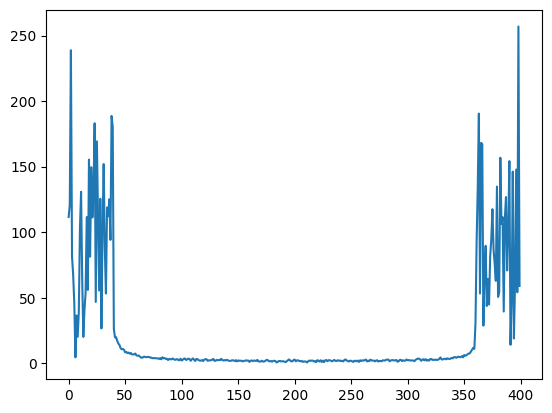

In [169]:
plt.plot(np.abs(y_long_ft))

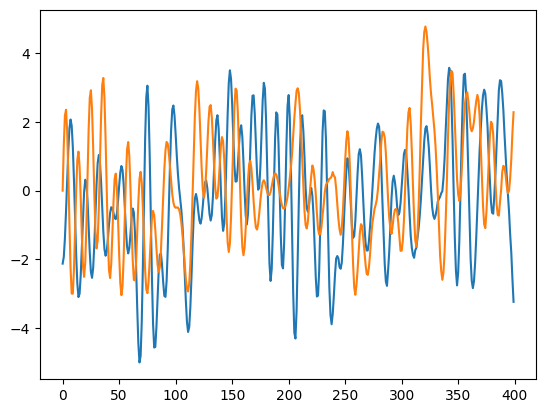

In [154]:
plt.plot(y_long.real)
plt.plot(y_long.imag)

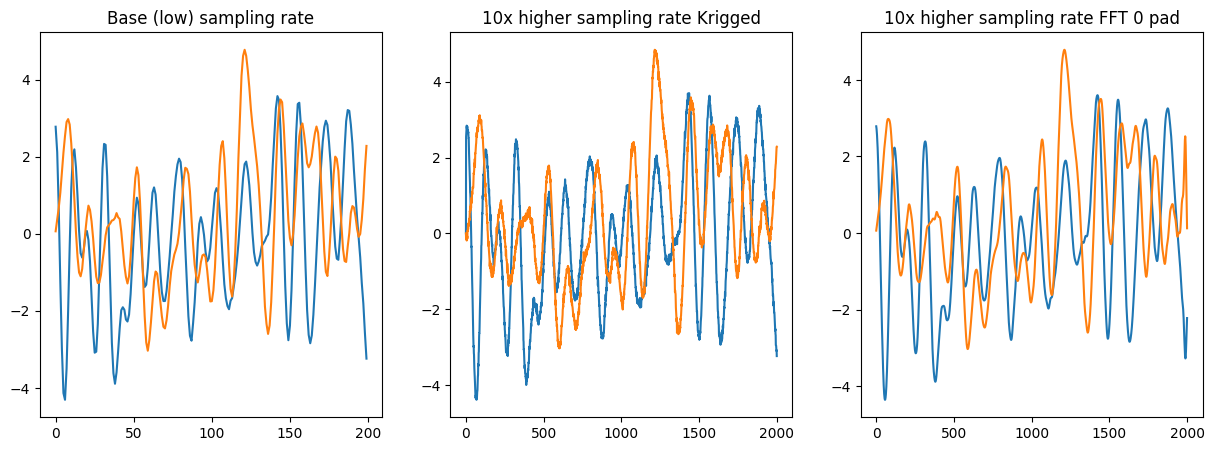

In [180]:
f=plt.gcf()
f.set_size_inches(15,5)
plt.subplot(131)
plt.title("Base (low) sampling rate")
plt.plot(y_long.real[200:])
plt.plot(y_long.imag[200:])
plt.subplot(132)
plt.title("10x higher sampling rate Krigged")
plt.plot(y_osamp.real)
plt.plot(y_osamp.imag)
plt.subplot(133)
plt.title("10x higher sampling rate FFT 0 pad")
plt.plot(y_osamp2[2000:].real)
plt.plot(y_osamp2[2000:].imag)

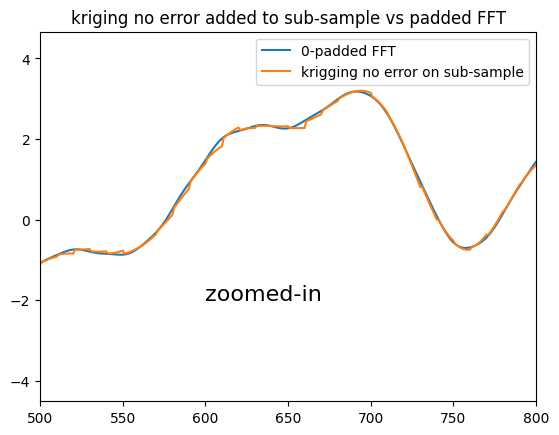

In [201]:
plt.plot(y_osamp2[2000:],label="0-padded FFT")
plt.plot(y_osamp_smooth[10:],label="krigging no error on sub-sample")
plt.title("kriging no error added to sub-sample vs padded FFT")
plt.text(600,-2,"zoomed-in",fontsize=16)
plt.xlim(500,500+300)
plt.legend()

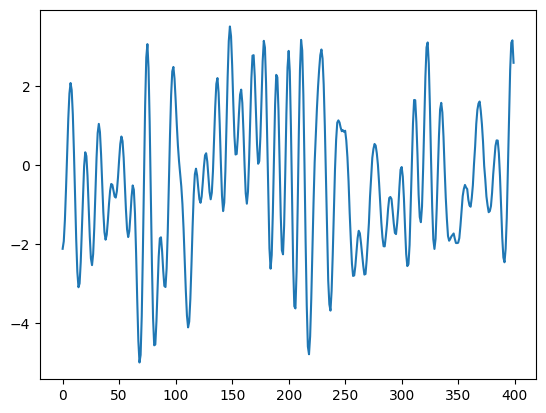

In [153]:
plt.plot(y_long_filled.real[:400]) #old simulation for shape comaprison

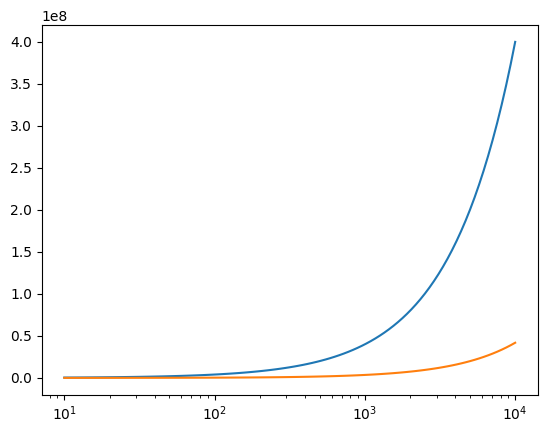

In [69]:
ps=(10**np.linspace(1,4,101)).astype(int)
plt.semilogx(ps,ps*nn**2)
plt.semilogx(ps,ps*nn*np.log2(ps*nn))
